# Description of columns
a date / data

the open price of the stock / o preço aberto do estoque

the highest price of the stock that day / o preço mais alto da ação naquele dia

the lowest price of the stock that day / o menor preço da ação naquele dia

the close price of the stock that day / o preço de fechamento da ação naquele dia

the adjusted close price / o preço de fechamento ajustado

the volume of trade (the number of stocks that were bought/sold that day) / o volume de comércio (o número de ações que foram compradas / vendidas naquele dia)

link
https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56

Documentação
https://docs.google.com/document/d/1LHEIxSty-u0I9SlX2vYeXStx2NpD7plA/edit#


# Pendências

* Checar ações aleatórias, self.epsilon - checar em quantos por cento o epsilon atua sobre o robo (ac_alea_pre) - documentar melhora no treinamento e nos testes se houver mais aleatorio e previsão - documentado - ok

* Checar batchsize, está causando efeito de que quanto maior o batchsize, mais aleatório fica o treinamento, a ponto de que acima de 1024 o treinamento ser todo aleatorio. Descobrir a causa e documentar. O motivo é pelo self.memory = deque(maxlen=1000) e ter uma logica que se o self memory for maior que batch size, ele fica entre aleatorio e previsão Quanto menor o batchsize, mais lento fica por usar mais vezes as previsões, ao invés da aleatoriedade. - não teve um efeito bom, documentado - ok

* fazer verificação de loss e accurancy - documentado - ok

* tentar melhorar rede neural com dropout, batchnormalization e mais camadas - documentar - ok

* comparar otimizadores nadam com rmsprop, documentar - ok

* testar early_stopping_monitor - documentar - ok

* verificar a causa de muitos dados, tempo prolongado, estarem ruins se está relacionado ao overfitting. Adicionar camadas dropout para proteger contra overfitting e fazer testes - o que melhor controla overfitting neste caso é o uso do early stopping monitor e dropout, testar com muitos dados - causa é overfitting

* Fator ganancioso gamma - não surgiu efeito, fazer mais testes - documentar- ok

* recompensa negativa (pensar em casos de recompensa exponencial, recompensas negativas para prejuízos) - documentar - ok

* vender as ações que estiverem na fila no final - documentar - ok

* Limpar fila de ações compradas, ou seja, não segurar ações com mais de 3 semanas. Checar na lista de dados e data se há dados com mais de 3 semanas, se houver faça a venda - documentar - ok

* testar engessar as primeiras rodadas (e.g. 10 rodadas comprando, 10 vendendo) e depois testar com fator epsilon e com previsão total - documentar - não

* ver questão de comprar e vender varios de uma vez - pendente

* loss control (quando começar a perder 10 por cento, vender)

* testar com varios periodos e ver o desempenho da rede neural

* script, entrar com dados

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import keras
import random
import matplotlib.pyplot as plt
import keras.backend as K
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input/dataset/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
#======================================================== Apple (AAPL), Microsoft (MSFT), and Chevron (CVX)
apple_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/AAPL.csv'
microsoft_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/MSFT.csv'
chevron_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/CVX.csv'

#======================================================== Amyris Inc (AMRS), Moneygram International (MGI), and Lovesac Co (LOVE)
amyris_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/AMRS.csv'
moneygram_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/MGI.csv'
lovesac_path = 'D:/Meus documentos/Trabalhos/python/exercicios/financerobot/LOVE.csv'

# Escolha a empresa

In [3]:
# Choose data frame

stock_name    = apple_path
#stock_name    = microsoft_path
#stock_name    = chevron_path
#stock_name    = amyris_path
#stock_name    = moneygram_path
#stock_name    = lovesac_path

# Função Pegar valores de Ações a partir do dataframe

In [4]:
# returns the vector containing stock data and date from a csv file
def _funcStockData(stock_name, is_eval=False):
    stock_data = []
    date = []
    
    df = pd.read_csv(stock_name)
    
    # sort by date
    df = df.sort_values('Date')
    
    # set date period
    if not is_eval:
        df = df[(df['Date'] >= '2017-05-15') & (df['Date'] < '2018-05-15')]
        #df = df[(df['Date'] >= '2018-01-01') & (df['Date'] < '2018-05-15')]
        print('Training data')
    else:
        df = df[df['Date'] >= '2018-05-15']
        print('Evaluation data')

    for i in range(df.shape[0]):
        stock_data.append(df['Close'].iloc[i])
        date.append(df['Date'].iloc[i])
    
    return stock_data, date

# Função Conversor de dias e formatar preço

In [5]:
def convert_day(date_time): 
    datetime_str = datetime.strptime(date_time, '%Y-%m-%d') 
    return datetime_str

# Function to covert list of string to datetime 
def convert_list(date_time): 
    datetime_str = [datetime.strptime(x, '%Y-%m-%d') for x in date_time]
    return datetime_str

# prints formatted price
def _formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# Função Profit or Loss calculation

In [6]:
# Profit or Loss calculation
def _profit_loss_calc(pr_los, is_eval=False):
    profit = 0
    loss   = 0
    even   = 0
    
    for i in range(0, len(pr_los)):
        if float(pr_los[i]) > 0:
            profit += 1
        elif float(pr_los[i]) < 0:
            loss += 1
        else:
            even += 1

    total = profit + loss
    res = (profit/total)*100
    
    if not is_eval:
        print('Training: PROFIT %.2f' %res + '% of the times')
    else:
        print('Evaluation: PROFIT %.2f' %res + '% of the times')
    return profit, loss, res

# Função State

In [7]:
# monta um array de representação de state com n-days num periodo de tempo - state
def _funcState(data, period, num_days):                                 # monta um array da diferença de valores entre um stock e um stock de um dia posterior            
    '''trabalha com periodo de 'num_days' dias'''
    d = period - num_days + 1                                           # quantos dias dentro de um periodo
    
    if d >= 0:                                                          # pad with period 0
        block = data[d : period + 1]                                    # pack with 'num_days' diferent days
    else:
        block = - d * [data[0]] + data[0 : period + 1]                  # pack with 'num_days' diferent days - d
    
    res = []
    for i in range(num_days - 1):
        res.append(block[i + 1] - block[i])                             # acumula a diferença de num_days de um dado period, só terá num_days diferentes quando d>=0
            
    return np.array([res])

# Função Agente

In [8]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_train=""):
        self.state_size = state_size                                    # normalized previous days, num_days
        self.action_size = 3                                            # hold, buy, sell or num_actions
        #self.memory = deque(maxlen=1000)                                # deeque com as informações de state, action, reward, next_state, done
        self.memory = deque(maxlen=33)                                  # deeque com as informações de state, action, reward, next_state, done
        self.inventory = []                                             # inventario do agente, acumula as compras. Quando há alguma venda, o primeiro dado do indice é extraido para calculo
        self.inventory_date = []                                        # inventario de data
        self.model_train = model_train                                  # modelo treinado
        self.is_eval = is_eval                                          # para checagem se é train ou avaliação
        self.gamma = 0.95                                               # fator de desconto y [0,1] equilibrar a recompensa imediata e futura
        
        '''equilibra exploration/exploitation usando epsilon e definir o valor de quantas vezes você deseja explorar vs exploit'''
        self.epsilon = 1                                                # factor epsilon, percent you want to explore, fator ganancioso
        self.epsilon_min = 0.01                                         # epsilon para efeito de comparação, epsilon usando para os calculos nunca será que ele
        self.epsilon_decay = 0.995                                      # valor de decaimento do epsilon para cada rodada
        '''==================================================================================================================='''
        
        # is it training or evaluation
        if is_eval:
            self.model = model_train                                    # for evaluation, load trained model
            print('Usando modelo treinado')
        else:
            self.model = self._model()                                  # in training, call _model function neural network
            print('Fazendo previsões')
        
        self.ac_alea = 0                                                # contador de ações aleatórias
        self.ac_pre = 0                                                 # contador de ações previstas
        
    def _model(self):                                                   # neural network Multilayer Perceptron Multi-class Classification type
        model = Sequential()                                            # Sequencial MLP convolutional neural network, Sequential model type
        model.add(Dense(32, input_dim = self.state_size, activation="relu"))  # fully connected layer, self.state_size num_days days as input
        model.add(BatchNormalization())                                 # BatchNormalization can adaptively normalize data even as the mean and variance change over time during training
        model.add(Dense(16, activation="relu"))                         # fully connected layer
        model.add(BatchNormalization())                                 # batch normalization makes sure that independently of the changes, the inputs to the next layer are normalized
        model.add(Dense(self.action_size, activation="linear"))         # a ultima camada se reduz em 3 outputs, que é a quantidade de possiveis ações a serem previstas 
        model.add(BatchNormalization())
        Nadam = keras.optimizers.Nadam(lr=0.001,
                                       beta_1=0.9, 
                                       beta_2=0.999, 
                                       epsilon=None, 
                                       schedule_decay=0.004)            # nadam optimizer
        model.compile(loss="mse",                                       # mean_squared_error
                      optimizer=Nadam,                                  # learning rate lr
                      metrics=['accuracy'])                             # compile using loss 'mse' and optimizer 'Adam'
        model.summary()                                                 # Summarize your model

#         model = RandomForestRegressor(n_estimators=23, random_state=42) ########################################################################

        return model
    
    def _action(self, state):                                           # action function, recebe array num_days, state = ([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])
        '''Agir aleatoriamente, ou seja, explorar. Em vez de selecionar ações com base na recompensa máxima futura, selecionamos uma ação aleatoriamente. 
        Atuar aleatoriamente é importante porque permite que o agente explore e descubra novos estados que, de outra forma, poderiam não ser selecionados
        durante o processo de exploração'''

        # explorar uma ação aleatória retorna o valor de uma proxima ação 0 hold,1 buy ou 2 sell 
        '''neste caso, quanto maior o self.epsilon, maior a chance de entrar em estado next_State randomico. EQUILIBRA as ações de exploit/exploring
        if random.uniform(0, 1) < epsilon: 
            Explore: select a random action'''
        '''caso não entre em estado de ação randomico acima, ele fará uma previsão da proxima ação com next_action
        else:
            Exploit: select the action with max value (future reward) '''
        
        if not self.is_eval and np.random.rand() <= self.epsilon:       # not self.is_eval' == training mode, np.random.rand() == Random values in a given shape
            '''Explore: select a random action'''
            
            self.ac_alea += 1                                           # contador de ações aleatórias
            
            return random.randrange(self.action_size), self.ac_alea, self.ac_pre # explorar uma ação aleatória retorna o valor de uma proxima ação 0 hold,1 buy ou 2 sell with DEBUG
        else:
            '''escolhe a ação com maximo valor dentro de next_action, onde nele estão as possiveis ações, O maior valor escolhido se refere a proxima ação a ser dada'''
            next_action = self.model.predict(state)                     # preve qual proxima ação
               
            self.ac_pre += 1                                            # contador de ações previstas
            
            return np.argmax(next_action[0]), self.ac_alea, self.ac_pre # retorna com a proxima ação. np.argmax with DEBUG
        
    def _experience_replay(self, batch_size):                           # experience_replay function
        mini_batch = []
        
        # amostra aleatória simples, coleta batch_size amostras de self.memory
        minibatch = random.sample(self.memory, batch_size)              # converte uma self.memory maior numa self.memory menor do tamanho de batch_size para ser usado nas previsões
        
        states      = np.array([tup[0][0] for tup in minibatch])        # transfere states vindo de self.memory e coloca em states tup[0][0] pois ele copia uma linha vazia como uma terceira dimensão da matrix
        actions     = np.array([tup[1]    for tup in minibatch])        # actions
        rewards     = np.array([tup[2]    for tup in minibatch])        # rewards
        next_states = np.array([tup[3][0] for tup in minibatch])        # next state
        done        = np.array([tup[4]    for tup in minibatch])        # done
        
        # Q(s', a) --------------------------------------------------------------------------------------------------------------------------
        '''Q [estado, ação] = Q [estado, ação] + lr * (recompensa + gama * np.max (Q [new_state,:]) - Q [estado, ação])
        a taxa de aprendizagem 'lr' usada na compilação do modelo (model.compile) com otimizador adam'''
        # com o next state calculado no inicio da rodada, agora será calculado o target pro next_state
#         self.model.fit(next_states, states) ########################################################################
        target = rewards + self.gamma * np.amax(self.model.predict(next_states), axis=1)
        ''' Usa a biblioteca numpy np.amax e está tirando o máximo da recompensa futura e aplicando-a à recompensa pelo estado atual. 
        O que isto faz é impactar a ação atual pela possível recompensa futura. 
        Estamos alocando recompensas futuras às ações atuais para ajudar o agente a selecionar a ação de retorno mais alta em qualquer estado. '''
        # alvo de estado final é recompensa em si (sem olhar para frente)
        target[done] = rewards[done]    

        # Q(s, a) --------------------------------------------------------------------------------------------------------------------------
        target_f = self.model.predict(states)                        # faz previsão de um valor maximo de recompensa pro atual state, preve qual proxima ação
        '''assim como em action, baseado nos valores de state atualizados, preve novas ações para um dos 3 estados'''
        # faça o agente mapear aproximadamente o estado atual para uma recompensa descontada futura
        target_f[range(batch_size), actions] = target                # salva o target para ação atual
        '''salva o target calculado anteriormente no lugar do target_f posição action'''
        
        # fit the model --------------------------------------------------------------------------------------------------------------------
        early_stopping_monitor = EarlyStopping(monitor='val_loss',    # allows you to specify the performance measure to monitor in order to end training
                                               patience=10,           # número de épocas sem melhora após o qual o treinamento será interrompido
                                               mode='auto',           # No modo `min`, o treinamento parará quando a quantidade monitorado parou de diminuir; em `max`modo vai parar quando a quantidade monitorado parou de aumentar
                                               baseline=None,         # O treinamento será interrompido se o modelo não mostrar melhora sobre a linha de base
                                               restore_best_weights=True) # para restaurar pesos de modelo de a época com o melhor valor da quantidade monitorada
        self.model.fit(states,
                       target_f,
                       epochs=100,
                       batch_size=batch_size,
                       verbose=0,
                       validation_split=0.3,
                       callbacks=[early_stopping_monitor])

#         self.model.fit(next_states, states) ########################################################################
       
        '''epochs corresponde a todos os nossos dados de treinamento que passam pelo rede uma vez e as respectivas 
        atualizações de weight durante a retropropagação. Como o nosso modelo está sendo treinado, nós teremos alguma saída mostrando o progresso'''
        
        if self.epsilon > self.epsilon_min:                          # para cada rodada de previsão há um decaimento na taxa de exploração
            self.epsilon *= self.epsilon_decay
            #print('self.epsilon', self.epsilon)
        '''equilibra exploration/exploitation DIMINUINDO o epsilon automaticamente a cada rodada de atualização de q-table
           para diminuir taxa de vezes que se deseja explorar vs exploit'''


# Maquina de estados

In [9]:
def _fsm(state, total_profit, is_eval=False):
    for period in range(length):                                                 # period of dataframe length 
        # take some action
        #              _action(self, state)
        action = agent._action(state)[0]                                         # action recebe uma ação prevista
        '''1. executa uma primeira ação (a1)'''                                  # 0 (hold) 1 (Buy) 2 (Sell) 

        # next_state  _funcState(data, period, n)
        next_state =  _funcState(data, period + 1, num_days + 1)                 # go to next state (period + 1), baseado no periodo de tempo seguinte, getState(data, period, n)
        '''monta a tabela state para o next_state'''
        
        reward = 0                                                               # start reward

        # checa se há itens restantes no final do treinamento e do evaluation
        if period == length - 1:
            action = 2

        # checa se há itens com mais de 3 meses
        current_day = convert_day(date[period])
        list_days   = convert_list(agent.inventory_date)
        three_weeks = timedelta(days=21)
        
        for i in range(len(agent.inventory_date)):
            if list_days[i] + three_weeks <= current_day:
                print('*** The value action ' + _formatPrice(agent.inventory[i]) + ' of the day ' + agent.inventory_date[i] + ' has been on the list for more than 3 weeks and will be sold ***')
                action = 2
        
        # BUY action
        if action == 1:                                                          
           
            buy_set[0].append(period)                                            # for plot, save buy point by period
            buy_set[1].append(data[period])                                      # for plot, save buy point by data at period

            agent.inventory.append(data[period])                                 # ADICIONA na lista agent.inventory o stock atual comprado
            agent.inventory_date.append(date[period])                            # ADICIONA na lista agent.inventory_date a data do stock atual comprado

            # for output
            if not is_eval:                                                      # training
                date_list.append(date[period])                                   # date
                action_list.append('Buy')                                        # action
                price_list.append(_formatPrice(data[period]))                    # price
                pr_los_list.append('0')                                          # profit or loss
                reward_list.append('0')                                          # reward
            else:                                                                # evaluation
                date_list_eval.append(date[period])                              # date
                action_list_eval.append('Buy')                                   # action
                price_list_eval.append(_formatPrice(data[period]))               # price
                pr_los_list_eval.append('0')                                     # profit or loss
                reward_list_eval.append('0')                                     # reward

            print('Buy: ' + _formatPrice(data[period]) + ' | Data: ' + date[period])

        # SELL action
        elif action == 2 and len(agent.inventory) > 0:                           # len(agent.inventory) > 0 pois o agente precisa ter pelo menos uma compra acumulada
            
            sell_set[0].append(period)                                           # for plot, save sell point by period
            sell_set[1].append(data[period])                                     # for plot, save sell point by data at period

            # calcula o lucro ou recompensa
            bought_price = agent.inventory.pop(0)                                # retorna o primeiro valor da lista 'agent.inventory' preenchida a partir da ultima sequencia de compras da action BUY
            '''pega o primeiro stock comprado disponivel na lista agent.inventory, salva em bought_price e retira este stock mesmo da lista'''
            
            # descarta a data da ação vendida
            agent.inventory_date.pop(0)

            # checa se há itens restantes e os vende
            if period == length - 1:
                if len(agent.inventory) > 0:
                    print('*** There are still ' + str(len(agent.inventory)) + ' stocks on the list ***')
                    for j in range(len(agent.inventory)):
                        bought_price = agent.inventory.pop(0)                    # retorna o primeiro valor da lista 'agent.inventory' preenchida a partir da ultima sequencia de compras da action BUY
                        agent.inventory_date.pop(0)                              # descarta a data da ação vendida
                        action_profit = data[period] - bought_price              # calcula lucro ou prejuizo NA AÇÃO
                        total_profit += data[period] - bought_price              # lucro ou prejuizo TOTAL ACUMULADO
                        if (data[period] - bought_price) >= 0:
                            print ('Sell list: ' + _formatPrice(data[period]) + ' | Bought Price ' + _formatPrice(bought_price) + ' | Profit: ' + _formatPrice(action_profit)  + ' | Data: ' + date[period])
                        else:
                            print ('Sell list: ' + _formatPrice(data[period]) + ' | Bought Price ' + _formatPrice(bought_price) + ' | Loss: ' + _formatPrice(action_profit)  + ' | Data: ' + date[period])
                else:
                    print('*** Empty stock list ***')
            
            # função recompensa
            reward = max(data[period] - bought_price, 0)                         # calcula a diferença maxima entre e o valor de uma das ações do periodo atual - primeiro valor da lista de comprados
            '''neste caso a diferença entre data do periodo atual menos valor de bought_price, sendo limitado para baixo em 0, ou seja, a recompensa nunca será menor que 0'''
            '''1. Recebe a recompensa, baseado no lucro do periodo'''
            
            action_profit = data[period] - bought_price                          # calcula lucro ou prejuizo NA AÇÃO
            total_profit += data[period] - bought_price                          # lucro ou prejuizo TOTAL ACUMULADO

            # for output
            if not is_eval:                                                      # training
                date_list.append(date[period])                                   # date
                action_list.append('Sell')                                       # action
                price_list.append(_formatPrice(data[period]))                    # price
                pr_los_list.append(action_profit)                                # profit or loss
                reward_list.append(reward)                                       # reward
            else:                                                                # evaluation
                date_list_eval.append(date[period])                              # date
                action_list_eval.append('Sell')                                  # action
                price_list_eval.append(_formatPrice(data[period]))               # price
                pr_los_list_eval.append(action_profit)                           # profit or loss
                reward_list_eval.append(reward)                                  # reward

            if period != length - 1:                                             # evita de mostrar venda 2 vezes, caso tenha vendido varias ações na ultima rodada
                if (data[period] - bought_price) >= 0:
                    print ('Sell: ' + _formatPrice(data[period]) + ' | Bought Price ' + _formatPrice(bought_price) + ' | Profit: ' + _formatPrice(action_profit)  + ' | Data: ' + date[period])
                else:
                    print ('Sell: ' + _formatPrice(data[period]) + ' | Bought Price ' + _formatPrice(bought_price) + ' | Loss: ' + _formatPrice(action_profit)  + ' | Data: ' + date[period])
        
        # verifique se o período calculado é igual ao comprimento do dataframe, se sim, encerra
        if period == length - 1:                                                 
            done = True                                                          # show results
        else:
            done = False                                                         # keep calc

        # atualiza a recompensa para a proxima ação for state, action, reward, next_state, done in mini_batch:
        agent.memory.append((state, action, reward, next_state, done))           # preenche e atualiza o deeque com as informações de state, action, reward, next_state, done

        # state receive next state
        '''tabela de state recebe o next_state já calculado com o state do proximo periodo'''
        state = next_state                                                       # state receive next state
       
        if done:
            if total_profit >= 0:
                print ("--------------------------------")
                print ("Total Profit: " + _formatPrice(total_profit))
                print ("--------------------------------")
                print ('Total de ações Aleatórias',agent._action(state)[1])
                print ('Total de ações Previstas',agent._action(state)[2])
            else:
                print ("--------------------------------")
                print ("Total Loss: " + _formatPrice(total_profit))
                print ("--------------------------------")
                print ('Total de ações Aleatórias',agent._action(state)[1])
                print ('Total de ações Previstas',agent._action(state)[2])

        '''3. Atualizar valores-q'''
        '''a principio o robo inicia em modo aleatório batch_size vezes até len(agent.memory) ser maior que esse, a partir disto
        no decorrer das vezes que a função _experience_replay for chamada, haverá decaimento em 'epsilon', diminuindo a possibilidade do robo
        continuar em modo aleatório e consequentemente prevendo mais suas ações'''
        if not is_eval:
            # for training
            if len(agent.memory) > batch_size:                                   # se o agente memory estiver maior que o batch size
                agent._experience_replay(batch_size)                             # chama a função _experience_replay e atualiza novos valors pra q
                '''com o next_state já definido e calculado, chama a função _experience_replay para se calcular o novo valor de recompensa futura'''


# Função visualizador de dados

In [10]:
def data_visualization(data, date, num_days, buy_set, sell_set):
    plt.figure(figsize = (28,12))
    plt.plot(data)
    plt.xticks(range(0, len(date), num_days), date[::num_days], rotation=45)
    plt.scatter(buy_set[0], buy_set[1], color="green", label='BUY')
    plt.scatter(sell_set[0], sell_set[1], color="red", label='SELL')
    plt.legend(loc='upper right')
    return plt.show()

# Dataframe

In [11]:
# Choose data frame

stock_name    = apple_path    # bom com 5 anos e 1 round
#stock_name    = microsoft_path
#stock_name    = chevron_path
#stock_name    = amyris_path   # modelo bom com 10 rounds
#stock_name    = moneygram_path
#stock_name    = lovesac_path

# Training

In [12]:
#num_days   = 10                                                                  # days
num_days   = 64                                                                  # days
episode_count = 0                                                                # repetições de treinamento

agent       = Agent(num_days)                                                    # agent function
stock_data  = _funcStockData(stock_name)                                         # returns the vector containing stock data and date from a csv file
data        = stock_data[0]                                                      # vector with data
date        = stock_data[1]                                                      # vector with date
length      = len(data) - 1                                                      # length of data
batch_size  = 32                                                                 # define periodo de tempo considerado para as previsões
#batch_size  = 64                                                                 # define periodo de tempo considerado para as previsões






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
_________________________________________________________________
batch_normalization_3 (Batch (None, 3)                 12        
Total params: 2,863
Trainable params: 2,761
Non-trainable params: 102
_____________________________________________

In [13]:
for rounds in range(episode_count + 1):
    print ("Episode " + str(rounds) + "/" + str(episode_count))
    
    #       _funcState(data, period, n)
    state = _funcState(data, 0, num_days + 1)                                    # START a estate, vai se basear no periodo de tempo 0
    #print('############################### STATE ###############################', state)
    '''1. Agente inicia em um estado (s1) '''

    total_profit = 0                                                             # start total_profit    
    agent.inventory = []                                                         # initialize agent inventory   
    agent.inventory_date = []                                                    # initialize agent inventory date

    # to plot data
    buy_set     = [[], []]                                                       # for plot, save buy point ############################################
    sell_set    = [[], []]                                                       # for plot, save sell point ############################################
    
    date_list   = []                                                             # date
    action_list = []                                                             # action
    price_list  = []                                                             # price
    pr_los_list = []                                                             # profit or loss
    reward_list = []                                                             # reward
    
    _fsm(state, total_profit)
        
    # model creation
    if rounds % 10 == 0:                                                          ############################################
        model_train = agent.model                                                 # save the model for future evaluation

Episode 0/0
Buy: $155.70 | Data: 2017-05-15
Sell: $155.47 | Bought Price $155.70 | Loss: -$0.23 | Data: 2017-05-16
Buy: $153.34 | Data: 2017-05-24
Sell: $153.61 | Bought Price $153.34 | Profit: $0.27 | Data: 2017-05-26
Buy: $153.93 | Data: 2017-06-05
Sell: $154.45 | Bought Price $153.93 | Profit: $0.52 | Data: 2017-06-06
Buy: $154.99 | Data: 2017-06-08
Sell: $148.98 | Bought Price $154.99 | Loss: -$6.01 | Data: 2017-06-09
Buy: $145.42 | Data: 2017-06-12
Buy: $146.59 | Data: 2017-06-13
Buy: $145.16 | Data: 2017-06-14
Buy: $144.29 | Data: 2017-06-15
Buy: $142.27 | Data: 2017-06-16
Sell: $145.01 | Bought Price $145.42 | Loss: -$0.41 | Data: 2017-06-20
Buy: $145.87 | Data: 2017-06-21
Sell: $145.63 | Bought Price $146.59 | Loss: -$0.96 | Data: 2017-06-22
Sell: $145.82 | Bought Price $145.16 | Profit: $0.66 | Data: 2017-06-26
Sell: $143.73 | Bought Price $144.29 | Loss: -$0.56 | Data: 2017-06-27
Buy: $145.83 | Data: 2017-06-28
Buy: $143.68 | Data: 2017-06-29

Buy: $143.50 | Data: 2017-07-03


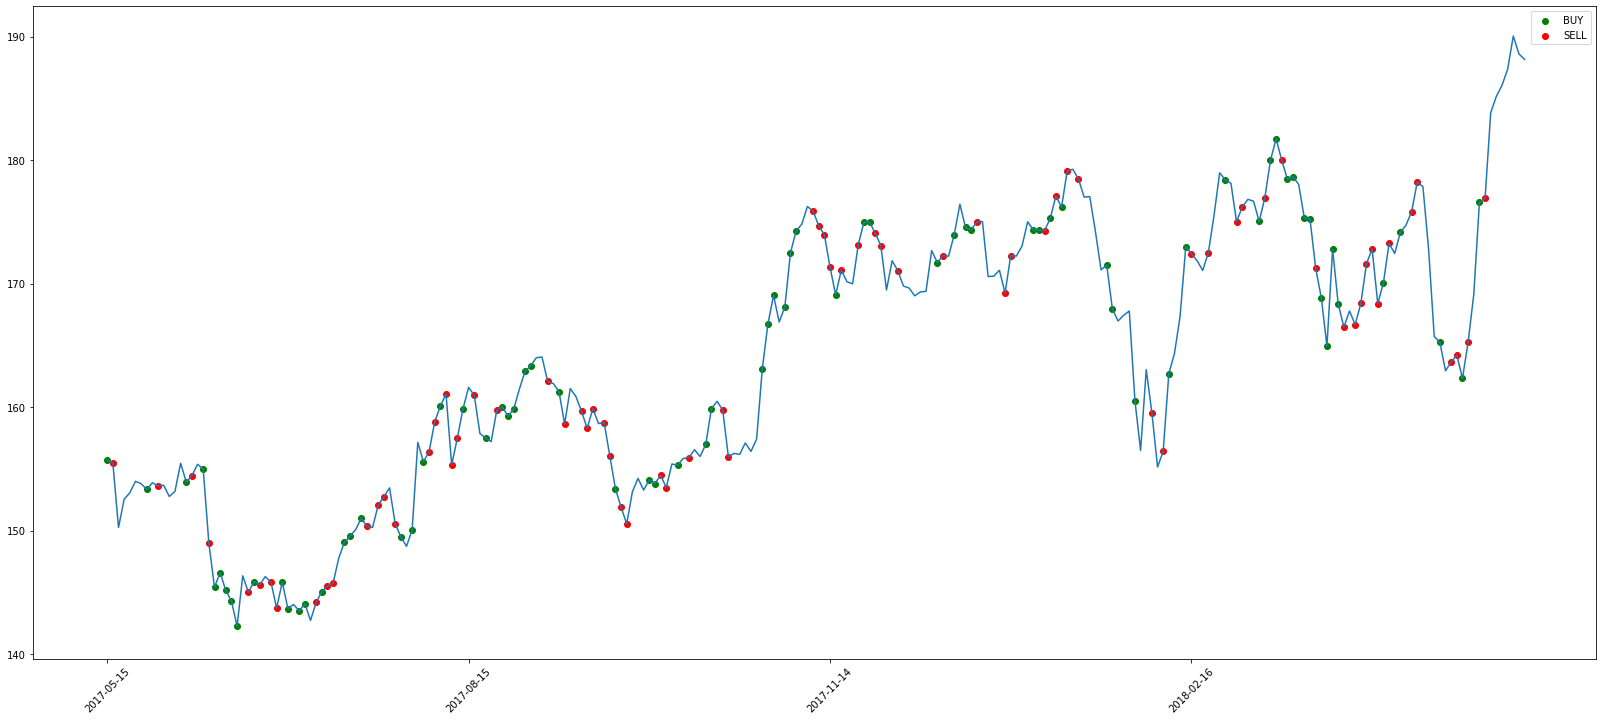

In [14]:
data_visualization(data, date, num_days, buy_set, sell_set)

In [15]:
training_calc = _profit_loss_calc(pr_los_list)

Training: PROFIT 54.67% of the times


# Dataframe

In [16]:
# Choose data frame

stock_name    = apple_path
#stock_name    = microsoft_path
#stock_name    = chevron_path
#stock_name    = amyris_path
#stock_name    = moneygram_path
#stock_name    = lovesac_path

# Evaluation

In [17]:
model = model_train
#num_days = model.layers[0].input.shape.as_list()[1]                          # getting days used in last model using convolutional neural networks
num_days = 64

agent       = Agent(num_days, True, model)                                   # agent function ******* SET True for evaluation data *******
stock_data  = _funcStockData(stock_name, True)                               # returns the vector containing stock data and date from a csv file ******* SET True for evaluation data *******
data        = stock_data[0]                                                  # vector with data
date        = stock_data[1]                                                  # vector with date
length      = len(data) - 1                                                  # length of data

Usando modelo treinado
Evaluation data


In [18]:
#       _funcState(data, period, n)
state = _funcState(data, 0, num_days + 1)                                    # START a estate, _State(data, period, n), vai se basear no periodo de tempo 0  
'''1. Agente inicia em um estado (s1) '''
total_profit = 0                                                             # start total_profit
agent.inventory = []                                                         # agent inventory

# to plot data
buy_set          = [[], []]                                                  # for plot, save buy point ############################################
sell_set         = [[], []]                                                  # for plot, save sell point ############################################

date_list_eval   = []                                                        # date
action_list_eval = []                                                        # action
price_list_eval  = []                                                        # price
pr_los_list_eval = []                                                        # profit or loss
reward_list_eval = []                                                        # reward

_fsm(state, total_profit, True)                                              # fsm function ******* SET True for evaluation data *******

Buy: $186.44 | Data: 2018-05-15
Buy: $188.18 | Data: 2018-05-16
Sell: $186.99 | Bought Price $186.44 | Profit: $0.55 | Data: 2018-05-17
Sell: $187.63 | Bought Price $188.18 | Loss: -$0.55 | Data: 2018-05-21
Buy: $188.15 | Data: 2018-05-24
Sell: $188.58 | Bought Price $188.15 | Profit: $0.43 | Data: 2018-05-25
Buy: $187.50 | Data: 2018-05-30
Sell: $186.87 | Bought Price $187.50 | Loss: -$0.63 | Data: 2018-05-31
Buy: $190.70 | Data: 2018-06-13
Buy: $190.80 | Data: 2018-06-14
Sell: $188.84 | Bought Price $190.70 | Loss: -$1.86 | Data: 2018-06-15
Buy: $188.74 | Data: 2018-06-18
Buy: $185.46 | Data: 2018-06-21
Buy: $182.17 | Data: 2018-06-25
Buy: $184.43 | Data: 2018-06-26
Sell: $184.16 | Bought Price $190.80 | Loss: -$6.64 | Data: 2018-06-27
Buy: $185.11 | Data: 2018-06-29
Buy: $187.18 | Data: 2018-07-02
Sell: $183.92 | Bought Price $188.74 | Loss: -$4.82 | Data: 2018-07-03
Sell: $187.97 | Bought Price $185.46 | Profit: $2.51 | Data: 2018-07-06
Buy: $190.58 | Data: 2018-07-09
Sell: $191.03

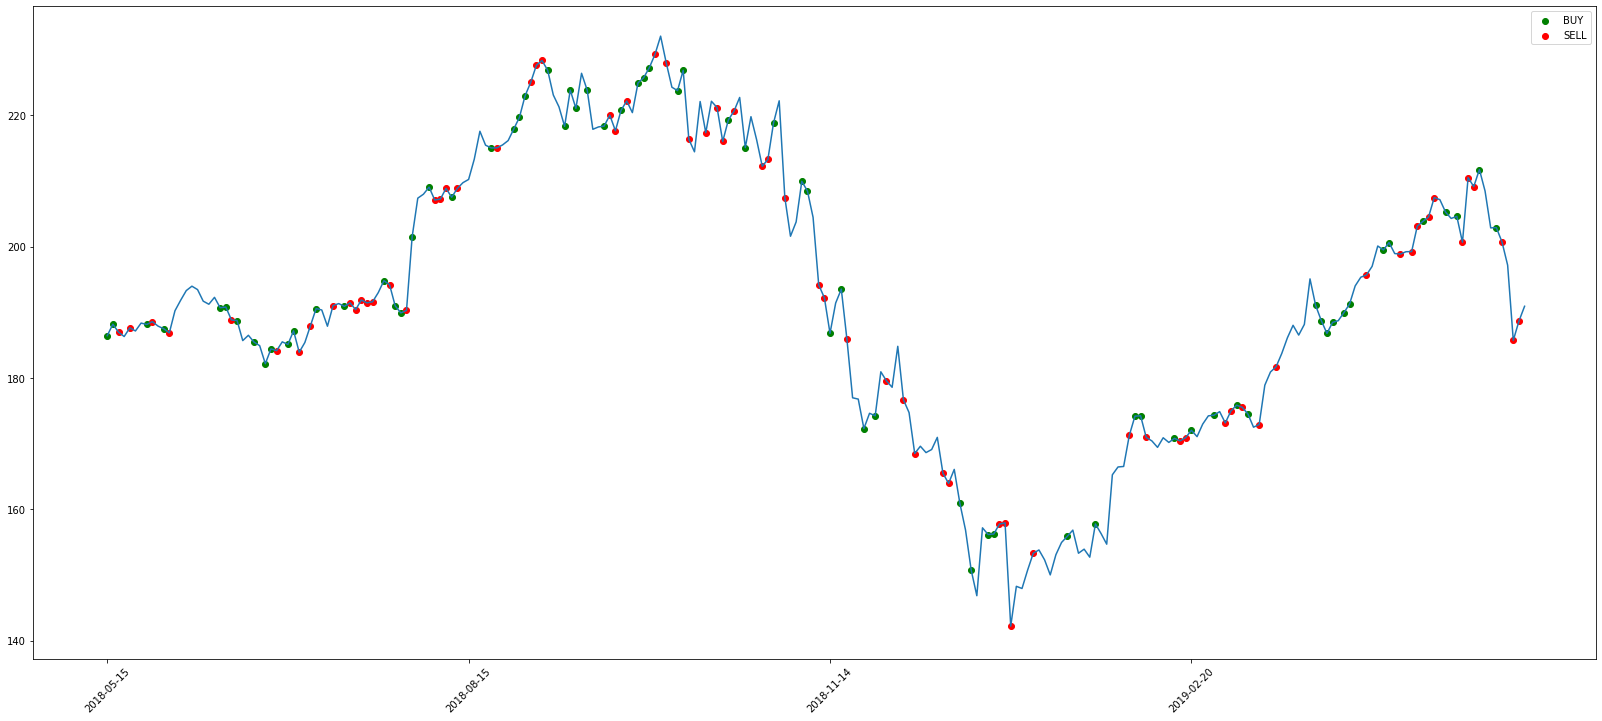

In [19]:
data_visualization(data, date, num_days, buy_set, sell_set)

In [20]:
eval_calc = _profit_loss_calc(pr_los_list_eval, True)

Evaluation: PROFIT 48.57% of the times


# Função debug

* Layer 0 ===================================================================================================

Input: Tensor("dense_1_input:0", shape=(?, 64), dtype=float32)
Output: Tensor("dense_1/Relu:0", shape=(?, 32), dtype=float32)
Weights: [<tf.Variable 'dense_1/kernel:0' shape=(64, 32) dtype=float32_ref>, <tf.Variable 'dense_1/bias:0' shape=(32,) dtype=float32_ref>]
weights0[0].shape (64, 32)


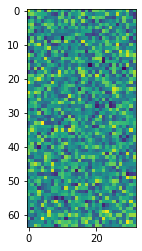

In [21]:
# Get the input and output tensors of a model layer
inp0 = model.layers[0].input
out0 = model.layers[0].output
print('Input:', inp0)
print('Output:', out0)
print('Weights:', model.layers[0].weights)

# Function that maps layer inputs to outputs
inp_to_out0 = K.function([inp0],[out0])

#convolutional layer model.layers[0]
weights0 = model.layers[0].get_weights()
len(weights0)
# kernel weights1[0]
print('weights0[0].shape', weights0[0].shape)
plt.imshow(weights0[0])

* Layer 1 ===================================================================================================

Input: Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 32), dtype=float32)
Output: Tensor("dense_2/Relu:0", shape=(?, 16), dtype=float32)
Weights: [<tf.Variable 'dense_2/kernel:0' shape=(32, 16) dtype=float32_ref>, <tf.Variable 'dense_2/bias:0' shape=(16,) dtype=float32_ref>]
(32, 16)


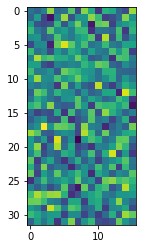

In [22]:
# Get the input and output tensors of a model layer
inp2 = model.layers[2].input
out2 = model.layers[2].output
print('Input:', inp2)
print('Output:', out2)
print('Weights:', model.layers[2].weights)

# Function that maps layer inputs to outputs
inp_to_out2 = K.function([inp2],[out2])

#convolutional layer model.layers[1]
weights2 = model.layers[2].get_weights()
len(weights2)
# kernel weights2[0]
print(weights2[0].shape)
plt.imshow(weights2[0])

* Layer 2 ===================================================================================================

Input: Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 16), dtype=float32)
Output: Tensor("dense_3/BiasAdd:0", shape=(?, 3), dtype=float32)
Weights: [<tf.Variable 'dense_3/kernel:0' shape=(16, 3) dtype=float32_ref>, <tf.Variable 'dense_3/bias:0' shape=(3,) dtype=float32_ref>]
(16, 3)


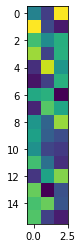

In [23]:
# Get the input and output tensors of a model layer
inp4 = model.layers[4].input
out4 = model.layers[4].output
print('Input:', inp4)
print('Output:', out4)
print('Weights:', model.layers[4].weights)

# Function that maps layer inputs to outputs
inp_to_out4 = K.function([inp4],[out4])

#convolutional layer model.layers[1]
weights4 = model.layers[4].get_weights()
len(weights4)
# kernel weights4[0]
print(weights4[0].shape)
plt.imshow(weights4[0])

# Export to csv file

The output of the prototype is a table that shows:

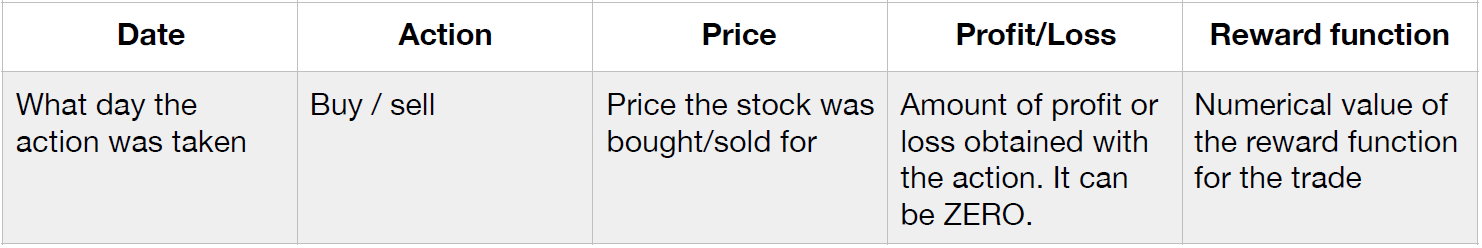

The bot should output that table to a file, where the details of the run scenario are also present.
Another output is the percentage of the times the bot had a PROFIT trade (e.g., PROFIT 70% of
the times).

In [24]:
# output generator
output = pd.DataFrame({'Date': date_list,
                       'Action' : action_list,
                       'Price': price_list,
                       'Profit / Loss': pr_los_list,
                       'Reward': reward_list
                      })

# output_eval generator
output_eval = pd.DataFrame({'Date': date_list_eval,
                           'Action' : action_list_eval,
                           'Price': price_list_eval,
                           'Profit / Loss': pr_los_list_eval,
                           'Reward': reward_list_eval
                          })

In [25]:
# file name
filename      = 'submission.csv'
filename_eval = 'submission_eval.csv'

# csv creator
output.to_csv(filename, index=False)
output_eval.to_csv(filename_eval, index=False)
print('Saved file: ' + filename)
print('Saved file: ' + filename_eval)

Saved file: submission.csv
Saved file: submission_eval.csv


# Reading CSV file

Reading CSV file to check

In [26]:
# reading csv
reading_output = pd.read_csv('submission.csv')
print(reading_output)

           Date Action    Price  Profit / Loss    Reward
0    2017-05-15    Buy  $155.70       0.000000  0.000000
1    2017-05-16   Sell  $155.47      -0.229996  0.000000
2    2017-05-24    Buy  $153.34       0.000000  0.000000
3    2017-05-26   Sell  $153.61       0.270005  0.270005
4    2017-06-05    Buy  $153.93       0.000000  0.000000
..          ...    ...      ...            ...       ...
145  2018-04-26   Sell  $164.22      -1.020004  0.000000
146  2018-04-27    Buy  $162.32       0.000000  0.000000
147  2018-04-30   Sell  $165.26       2.939988  2.939988
148  2018-05-02    Buy  $176.57       0.000000  0.000000
149  2018-05-03   Sell  $176.89       0.319992  0.319992

[150 rows x 5 columns]


In [27]:
# reading csv
reading_output_eval = pd.read_csv('submission_eval.csv')
print(reading_output_eval)

           Date Action    Price  Profit / Loss    Reward
0    2018-05-15    Buy  $186.44       0.000000  0.000000
1    2018-05-16    Buy  $188.18       0.000000  0.000000
2    2018-05-17   Sell  $186.99       0.550003  0.550003
3    2018-05-21   Sell  $187.63      -0.549988  0.000000
4    2018-05-24    Buy  $188.15       0.000000  0.000000
..          ...    ...      ...            ...       ...
136  2019-05-03    Buy  $211.75       0.000000  0.000000
137  2019-05-08    Buy  $202.90       0.000000  0.000000
138  2019-05-09   Sell  $200.72      -4.559998  0.000000
139  2019-05-13   Sell  $185.72     -18.890000  0.000000
140  2019-05-14   Sell  $188.66     -14.239990  0.000000

[141 rows x 5 columns]
